# Report 2 by Eli Easton

## Title of Research Paper

Surge Pricing in the Airbnb Market: Insights from the 2017 Boston Marathon

## Research Summary

In April 2017, the Boston Marathon drew thousands of participants and media personnel, and tens of thousands of spectators to Boston, Massachusetts (Boston Athletic Association 2017). How, then, did this influx of visitors impact the Boston Airbnb market? I hypothesize that the Boston Marathon increased local demand for Airbnbs at the neighbourhood level, thus leading to a temporary spike in certain neighbourhood's Airbnb listing prices around the time of the marathon. The dataset used for my analysis follows a panel structure (listing-year-month) and consists of the Boston Airbnb listings and calendar datasets. My outcome variable of interest is listing price, and my x-variables include a "Boston Marathon" dummy, time indicators, distance indicators, and controls for listing and neighbourhood characteristics.

## Data Cleaning & Loading

In [ ]:
#! pip install -q matplotlib numpy pandas qeds seaborn stargazer

In [1]:
#Import libraries
import matplotlib
import matplotlib.colors as mplc
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as dates
import numpy as np
import pandas as pd
from pandas_datareader import DataReader
import qeds
import seaborn as sns

#Change font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

#Load calendar dataset
calendar = pd.read_csv("C:\\Users\\eliea\\Desktop\\UofTYear3\\Term_2\\Eco225\\"
                       "ECO225Project\\Data\\Boston\\calendar.csv")

#Clean "calendar"

#Rename "listing_id" column to "id"
calendar.rename(columns={"listing_id": "id"}, inplace=True)

#Clean price column to remove $ and zeroes, convert to float
calendar["price"] = calendar["price"].astype(str).str.replace("$", 
                    "").str.replace(".00", "").str.replace(",", "") \
                    .astype(float)

#Create "year_month" column from the "date" column in "df_calendar" dataset
#Convert "date" column to datetime
#Documentation: 
#https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
calendar["date"] = pd.to_datetime(calendar["date"])

#Create "year_month" column
calendar["year_month"] = calendar["date"].dt.to_period("M")

#Set calendar index
calendar.set_index("id")

#Load listings dataset
listings = pd.read_csv("C:\\Users\\eliea\\Desktop\\UofTYear3\\Term_2\\Eco225\\"
                    "ECO225Project\\Data\\Boston\\listings.csv").set_index("id")

#Clean "listings"

listings.drop(columns=["listing_url", "scrape_id", "last_scraped", "name", 
                       "summary", "space", "description", 
                       "experiences_offered", "neighborhood_overview", 
                       "notes", "transit", "access", "interaction", 
                       "house_rules", "thumbnail_url", "medium_url", 
                       "picture_url", "xl_picture_url", "host_id", 
                       "host_url", "host_name", "host_since", "host_location", 
                       "host_about", "host_response_time", 
                       "host_response_rate", "host_acceptance_rate", 
                       "host_thumbnail_url", "host_picture_url", 
                       "host_neighbourhood", "host_listings_count", 
                       "host_verifications", "host_has_profile_pic", 
                       "host_identity_verified", "neighbourhood", 
                       "neighbourhood_group_cleansed", "market", 
                       "smart_location", "country_code", "country", 
                       "is_location_exact", "weekly_price", "monthly_price", 
                       "calendar_updated", "has_availability", 
                       "availability_30", "availability_60", "availability_90", 
                       "availability_365", "calendar_last_scraped", 
                       "first_review", "last_review", 
                       "review_scores_accuracy", "review_scores_cleanliness", 
                       "review_scores_checkin", 
                       "review_scores_communication", "review_scores_location", 
                       "review_scores_value", "requires_license", 
                       "license", "jurisdiction_names", "instant_bookable", 
                       "cancellation_policy", "require_guest_profile_picture", 
                       "require_guest_phone_verification", 
                       "calculated_host_listings_count", "reviews_per_month", 
                       "state", "minimum_nights", "maximum_nights", 
                       "guests_included", "extra_people", "square_feet", 
                       "security_deposit", "price", "number_of_reviews"], 
                       inplace=True)

#Create dummy variables
#Superhost
listings["Superhost"] = listings["host_is_superhost"].map({"t": 1, "f": 0})

#Room type
for room in ["Entire home/apt", "Private room", "Shared room"]:
    listings[room] = listings["room_type"].map({room: 1}).fillna(0) \
    .astype(int)

#Property type
for property in ["Apartment", "House", "Condominium", "Townhouse", 
                 "Guesthouse", "Loft", "Villa", "Dorm", "Entire Floor", 
                 "Bed & Breakfast", "Boat", "Camper/RV", "Other"]:
    listings[property] = listings["property_type"].map({property: 1})\
    .fillna(0).astype(int)

#Bed type
for bed in ["Real Bed", "Futon", "Pull-out Sofa", "Couch", "Airbed"]:
    listings[bed] = listings["bed_type"].map({bed: 1}).fillna(0).astype(int)

#Neighbourhood
for neighbourhood in ["Allston", "Back Bay", "Bay Village", "Beacon Hill", 
                      "Brighton", "Charlestown", "Chinatown", "Dorchester",
                      "Downtown", "East Boston", "Fenway", "Hyde Park", 
                      "Jamaica Plain", "Longwood Medical Area", 
                      "Leather District", "Mattapan", "Mission Hill", 
                      "North End", "Roslindale", "Roxbury", 
                      "South Boston", "South Boston Waterfront", "South End", 
                      "West End", "West Roxbury"]:
    listings[neighbourhood] = listings["neighbourhood_cleansed"]\
    .map({neighbourhood: 1}).fillna(0).astype(int)

#Merge datasets on id
cal_lis = pd.merge(calendar, listings, on="id", how="outer")

#Load crime dataset
crime = pd.read_csv("C:\\Users\\eliea\\Desktop\\UofTYear3\\Term_2\\Eco225\\"
                    "ECO225Project\\Data\\crime.csv", encoding="latin1", 
                    low_memory=False)

#Clean "crime"

crime.drop(columns=["INCIDENT_NUMBER", "OFFENSE_CODE", 
                    "OFFENSE_DESCRIPTION", "DISTRICT", "REPORTING_AREA", 
                    "SHOOTING", "DAY_OF_WEEK", "HOUR", "UCR_PART", "Lat", 
                    "Long", "STREET"], inplace=True)

#Convert "OCCURRED_ON_DATE" column to datetime
crime["OCCURRED_ON_DATE"] = pd.to_datetime(crime["OCCURRED_ON_DATE"])

#Create "year_month_crime" column from the "OCCURRED_ON_DATE" column
crime["year_month_crime"] = crime["OCCURRED_ON_DATE"].dt.to_period("M")

#Filter dataset to include only data from September 2016 to September 2017
crime = crime[(crime["year_month_crime"] >= "2016-09") & 
              (crime["year_month_crime"] <= "2017-09")]

#Stack "cal_lis" and "crime" datasets
CalLisCrime = pd.concat([cal_lis, crime], axis = 0)

# Map Visualization

## Map 1: 

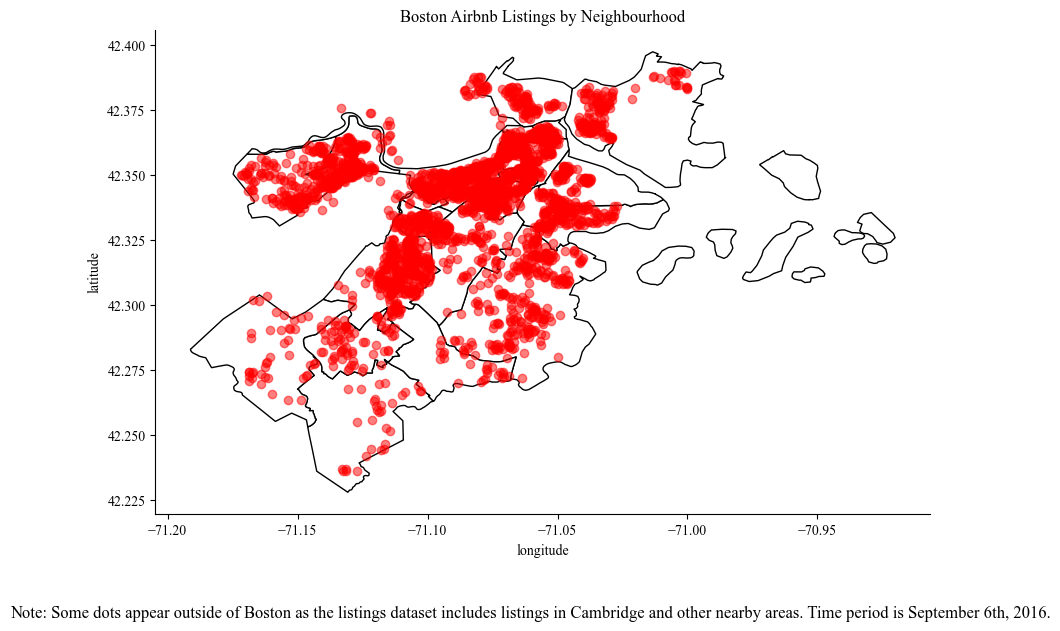

In [9]:
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point

#Create Coordinates column using latitude and longitude variables from listings
#As done in maps notebook
listings["Coordinates"] = list(zip(listings.longitude, listings.latitude))
listings["Coordinates"] = listings["Coordinates"].apply(Point)
#Turn listings into a geodataframe, as done in maps notebook 
listings_geo = gpd.GeoDataFrame(listings, geometry="Coordinates")



#Obtained from: https://data.boston.gov/dataset/boston-neighborhood-boundaries-approximated-by-2020-census-tracts
#Read Boston neighbourhoods file
neighbourhoods = gpd.read_file(r"C:\\Users\\eliea\\Desktop\\UofTYear3\\Term_2\\Eco225\\ECO225Project\\"
                               "boston_neighborhood_boundaries_approximated_by_2020_census_tracts.json")

#Create map
fig, gax = plt.subplots(figsize=(10,10))

#Plot Boston neighbourhoods
neighbourhoods.plot(ax=gax, edgecolor="black", color="white")

#Plot listings
listings_geo.plot(ax=gax, color="red", alpha=0.5)

#Create labels and title
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title("Boston Airbnb Listings by Neighbourhood") 

#Remove right and top spines
gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.figtext(0.5, 0.15, "Note: Some dots appear outside of Boston as the listings dataset includes listings in Cambridge and other \
nearby areas. Time period is September 6th, 2016.", horizontalalignment='center', fontsize=12)

plt.show()

#See map of Boston by Zip Codes here: https://www.cityofboston.gov/images_documents/ZipCodes_tcm3-47884.pdf
#See map of Boston by neighbourhoods here: https://en.wikipedia.org/wiki/Neighborhoods_in_Boston#/media/File:Boston_ONS_Neighborhoods.svg

## Interpretation

## Map 2:

## Interpretation

# Regression Table

## Interpretation

## Data Sources

## Bibliography

Boston Athletic Association Communications Department. 2017. "2017 Boston Marathon Will Mean $192.2 Million For Greater Boston Economy." *Boston Athletic Association*, March 23. https://www.baa.org/2017-boston-marathon-will-mean-1922-million-greater-boston-economy.